# Linear Regression-Case Study

In [1]:
#importing necessary files and libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#!pip install pandas_profiling 
import pandas_profiling 
import scipy.stats as stats
import statsmodels as sm
%matplotlib inline

import sklearn as sk

In [2]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import  Lasso, Ridge, ElasticNet

## Creating UDFs

In [3]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(),(x.isna().sum()/x.isna().count())*100, x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'PERCENT_MISSING','SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [4]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [5]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

In [6]:
def outlier_treatment(x):
    x=x.clip(upper=x.quantile(0.95), lower=x.quantile(0.05))
    return x

In [7]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

## Data import

In [8]:
card_spend=pd.read_excel('Data Set.xlsx')

## Data inspection

In [9]:
card_spend.head()

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,...,1,1,1,1,1,1,1,0,0,0
1,8795-FYOXCT-P09,5,2.0,0,44,4,March,10,1,1,...,1,0,1,0,0,0,0,0,0,0
2,0649-TBFJFL-QU4,5,2.0,0,63,5,May,14,2,6,...,1,0,0,0,0,0,1,0,0,0
3,2228-KOLOPU-FY3,5,5.0,1,28,3,April,11,1,1,...,1,1,0,0,0,0,0,1,0,0
4,4626-BQZAUJ-V9K,5,4.0,1,26,3,June,16,3,2,...,1,0,1,1,1,1,0,0,0,0


## Pandas profilling

In [10]:
#import pandas_profiling 
#pandas_profiling.ProfileReport(card_spend)

## Manually removing unnecessary variables

In [11]:
#card_spend=card_spend.drop(labels=['custid','agecat','birthmonth','empcat', 'income','inccat', 'spousedcat','addresscat','commutecat','cardtenurecat','card2tenurecat'], axis=1)
card_spend=card_spend.drop(labels=['custid','birthmonth', 'employ', 'address', 'commute','townsize','income'], axis=1)

## Creating y variable

In [12]:
card_spend['Total_spent']=card_spend['cardspent']+card_spend['card2spent']

In [13]:
card_spend=card_spend.drop(columns=['cardspent', 'card2spent'])

In [14]:
card_spend.shape

(5000, 122)

## EDA

In [15]:
for x in ['region','agecat','edcat','jobcat','union','empcat',
          'inccat','jobsat','marital','homeown','addresscat','carcatvalue','commutecat',
          'reason','polview','card','cardtype','cardbenefit',
         'cardtenurecat','card2','card2type','card2benefit','card2tenurecat',
         'bfast','internet']:
    card_spend[x]=card_spend[x].astype('object')

In [16]:
card_spend_num=card_spend.select_dtypes(['int64', 'float64'])

In [17]:
card_spend_cat=card_spend.select_dtypes(['object'])

In [18]:
card_spend_num.columns

Index(['gender', 'age', 'ed', 'retire', 'lninc', 'debtinc', 'creddebt',
       'lncreddebt', 'othdebt', 'lnothdebt', 'default', 'spoused',
       'spousedcat', 'reside', 'pets', 'pets_cats', 'pets_dogs', 'pets_birds',
       'pets_reptiles', 'pets_small', 'pets_saltfish', 'pets_freshfish',
       'hometype', 'cars', 'carown', 'cartype', 'carvalue', 'carbought',
       'carbuy', 'commutetime', 'commutecar', 'commutemotorcycle',
       'commutecarpool', 'commutebus', 'commuterail', 'commutepublic',
       'commutebike', 'commutewalk', 'commutenonmotor', 'telecommute',
       'polparty', 'polcontrib', 'vote', 'cardfee', 'cardtenure', 'card2fee',
       'card2tenure', 'active', 'tenure', 'churn', 'longmon', 'lnlongmon',
       'longten', 'lnlongten', 'tollfree', 'tollmon', 'lntollmon', 'tollten',
       'lntollten', 'equip', 'equipmon', 'lnequipmon', 'equipten',
       'lnequipten', 'callcard', 'cardmon', 'lncardmon', 'cardten',
       'lncardten', 'wireless', 'wiremon', 'lnwiremon', 'wire

In [19]:
card_spend_cat.columns

Index(['region', 'agecat', 'edcat', 'jobcat', 'union', 'empcat', 'inccat',
       'jobsat', 'marital', 'homeown', 'addresscat', 'carcatvalue',
       'commutecat', 'reason', 'polview', 'card', 'cardtype', 'cardbenefit',
       'cardtenurecat', 'card2', 'card2type', 'card2benefit', 'card2tenurecat',
       'bfast', 'internet'],
      dtype='object')

In [20]:
#Summary of continuous variables.
card_spend_num.apply(continuous_var_summary).T.round(3).sort_values(by='PERCENT_MISSING',ascending=False).head(12)

,N,NMISS,PERCENT_MISSING,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
lnwireten,1344.0,3656.0,73.12,9150.129,6.808,7.147,1.284,1.649,2.542,3.040,4.114,4.881,6.158,7.147,7.755,8.107,8.311,8.690,9.462
lnwiremon,1344.0,3656.0,73.12,4845.121,3.605,3.598,0.390,0.152,2.542,2.807,2.993,3.119,3.330,3.598,3.865,4.103,4.267,4.577,5.227
lnequipmon,1704.0,3296.0,65.92,6134.805,3.600,3.599,0.283,0.080,2.833,2.968,3.140,3.235,3.413,3.599,3.790,3.971,4.065,4.269,4.666
lnequipten,1704.0,3296.0,65.92,11497.393,6.747,7.051,1.199,1.438,2.489,3.170,4.251,5.033,6.172,7.051,7.650,7.978,8.118,8.369,8.783
lntollten,2378.0,2622.0,52.44,15658.615,6.585,6.858,1.222,1.493,2.169,2.785,4.208,4.821,5.912,6.858,7.460,7.883,8.107,8.430,8.843
lntollmon,2378.0,2622.0,52.44,7712.400,3.243,3.229,0.405,0.164,2.079,2.346,2.584,2.741,2.970,3.229,3.519,3.790,3.927,4.191,4.623
lncardten,3578.0,1422.0,28.44,22993.333,6.426,6.640,1.172,1.374,1.558,2.485,4.094,4.942,5.858,6.640,7.219,7.673,7.923,8.392,9.526
lncardmon,3581.0,1419.0,28.38,10419.753,2.910,2.904,0.565,0.319,1.179,1.658,1.981,2.169,2.546,2.904,3.296,3.638,3.839,4.239,5.239
lnlongten,4997.0,3.0,0.06,28039.656,5.611,5.858,1.649,2.720,-0.105,0.875,2.535,3.343,4.650,5.858,6.818,7.500,7.851,8.453,9.476
longten,4997.0,3.0,0.06,3542232.150,708.872,350.000,979.291,959011.004,0.900,2.400,12.620,28.290,104.600,350.000,913.850,1808.840,2567.650,4689.066,13046.500


In [21]:
#Summary of continuous variables.
card_spend_cat.apply(categorical_var_summary).T.round(3)

,N,NMISS,MODE,FREQ,PERCENT
region,5000.0,0.0,5.0,1027.0,20.54
agecat,5000.0,0.0,4.0,1222.0,24.44
edcat,5000.0,0.0,2.0,1567.0,31.34
jobcat,5000.0,0.0,2.0,1640.0,32.80
union,5000.0,0.0,0.0,4244.0,84.88
empcat,5000.0,0.0,2.0,1180.0,23.60
inccat,5000.0,0.0,2.0,1797.0,35.94
jobsat,5000.0,0.0,3.0,1085.0,21.70
marital,5000.0,0.0,0.0,2599.0,51.98
homeown,5000.0,0.0,1.0,3148.0,62.96


## Dropping columns having high missing values

In [22]:
missing=card_spend_num.isna().sum()/card_spend_num.isna().count()

In [23]:
missing[missing>0.25].index

Index(['lntollmon', 'lntollten', 'lnequipmon', 'lnequipten', 'lncardmon',
       'lncardten', 'lnwiremon', 'lnwireten'],
      dtype='object')

In [24]:
card_spend_num.drop(columns=missing[missing>0.25].index, inplace=True)

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [25]:
card_spend_num.shape

(5000, 89)

In [26]:
card_spend_cat.shape

(5000, 25)

In [27]:
card_spend.head()

,region,gender,age,agecat,ed,edcat,jobcat,union,empcat,retire,...,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03,Total_spent
0,5,0,22,2,17,4,2,0,1,0,...,1,1,1,1,1,1,0,0,0,77.54
1,5,0,44,4,10,1,1,0,4,0,...,0,1,0,0,0,0,0,0,0,732.75
2,5,0,63,5,14,2,6,1,5,0,...,0,0,0,0,0,1,0,0,0,1294.06
3,5,1,28,3,11,1,1,0,2,0,...,1,0,0,0,0,0,1,0,0,586.78
4,5,1,26,3,16,3,2,0,1,0,...,0,1,1,1,1,0,0,0,0,548.67


## Outlier treatment

In [28]:
#apply outlier treatment on numerical/continous variables.
card_spend_num=card_spend_num.apply(outlier_treatment)

In [29]:
#Summary of the continuous variables after applying outlier treatment.
card_spend_num.apply(continuous_var_summary).T.round(3)

,N,NMISS,PERCENT_MISSING,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
gender,5000.0,0.0,0.00,2518.000,0.504,1.000,0.500,0.250,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000
age,5000.0,0.0,0.00,234988.000,46.998,47.000,17.532,307.362,20.000,20.000,20.000,23.000,31.000,47.000,62.000,72.000,76.000,76.000,76.000
ed,5000.0,0.0,0.00,72719.000,14.544,14.000,3.132,9.808,9.000,9.000,9.000,10.000,12.000,14.000,17.000,19.000,20.000,20.000,20.000
retire,5000.0,0.0,0.00,738.000,0.148,0.000,0.355,0.126,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000
lninc,5000.0,0.0,0.00,18466.838,3.693,3.638,0.685,0.469,2.565,2.565,2.565,2.773,3.178,3.638,4.205,4.692,4.990,4.990,4.990
debtinc,5000.0,0.0,0.00,48824.800,9.765,8.800,5.739,32.933,1.900,1.900,1.900,2.800,5.100,8.800,13.600,18.600,22.200,22.200,22.200
creddebt,5000.0,0.0,0.00,7879.788,1.576,0.926,1.688,2.850,0.101,0.101,0.101,0.176,0.386,0.926,2.064,4.299,6.372,6.373,6.373
lncreddebt,4999.0,1.0,0.02,-598.917,-0.120,-0.076,1.139,1.296,-2.292,-2.292,-2.292,-1.738,-0.953,-0.076,0.725,1.459,1.852,1.852,1.852
othdebt,5000.0,0.0,0.00,16077.818,3.216,2.099,3.104,9.636,0.288,0.288,0.288,0.458,0.980,2.099,4.315,8.062,11.814,11.816,11.816
lnothdebt,4999.0,1.0,0.02,3507.717,0.702,0.742,1.017,1.034,-1.243,-1.243,-1.243,-0.780,-0.019,0.742,1.462,2.087,2.469,2.470,2.470


## Missing_value_treatment

In [30]:
#Apply missing value imputation of the remaining missing values
card_spend_num=card_spend_num.apply(missing_imputation)

In [31]:
card_spend_cat=card_spend_cat.apply(missing_imputation)

In [32]:
#Finally count the missing values.
card_spend_num.isna().sum().sort_values(ascending=False)

Total_spent          0
cardfee              0
cars                 0
carown               0
cartype              0
carvalue             0
carbought            0
carbuy               0
commutetime          0
commutecar           0
commutemotorcycle    0
commutecarpool       0
commutebus           0
commuterail          0
commutepublic        0
commutebike          0
commutewalk          0
commutenonmotor      0
telecommute          0
polparty             0
polcontrib           0
hometype             0
pets_freshfish       0
pets_saltfish        0
lnothdebt            0
age                  0
ed                   0
retire               0
lninc                0
debtinc              0
                    ..
ownpc                0
ownipod              0
owngame              0
ownfax               0
news                 0
response_01          0
response_02          0
voice                0
multline             0
wireten              0
tollfree             0
card2tenure          0
active     

In [33]:
#Finally count the missing values.
card_spend_cat.isna().sum().sort_values(ascending=False)

internet          0
carcatvalue       0
agecat            0
edcat             0
jobcat            0
union             0
empcat            0
inccat            0
jobsat            0
marital           0
homeown           0
addresscat        0
commutecat        0
bfast             0
reason            0
polview           0
card              0
cardtype          0
cardbenefit       0
cardtenurecat     0
card2             0
card2type         0
card2benefit      0
card2tenurecat    0
region            0
dtype: int64

In [34]:
card_spend=pd.concat([card_spend_num, card_spend_cat], axis=1)

In [35]:
card_spend.head()

,gender,age,ed,retire,lninc,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,...,card,cardtype,cardbenefit,cardtenurecat,card2,card2type,card2benefit,card2tenurecat,bfast,internet
0,0,22,17,0,2.708050,18.6,1.222020,0.200505,1.567980,0.449788,...,2,4,1,2,4,1,3,2,1,4
1,0,44,10,0,4.290459,2.8,1.250928,0.223886,0.793072,-0.231841,...,4,4,1,1,1,3,1,1,3,1
2,0,63,14,0,4.990433,10.7,6.373010,1.852297,11.815981,2.469586,...,3,3,2,5,2,3,3,5,1,0
3,1,28,11,0,3.135494,4.8,0.190992,-1.655524,0.913008,-0.091011,...,2,2,4,3,3,3,3,3,1,0
4,1,26,16,0,3.178054,11.7,1.297296,0.260282,1.510704,0.412576,...,4,1,1,3,1,2,3,2,3,4


## Creating correlation matrix

In [36]:
corrm=card_spend_num.corr()

In [37]:
corrm.to_excel('correlation_matrix.xlsx')

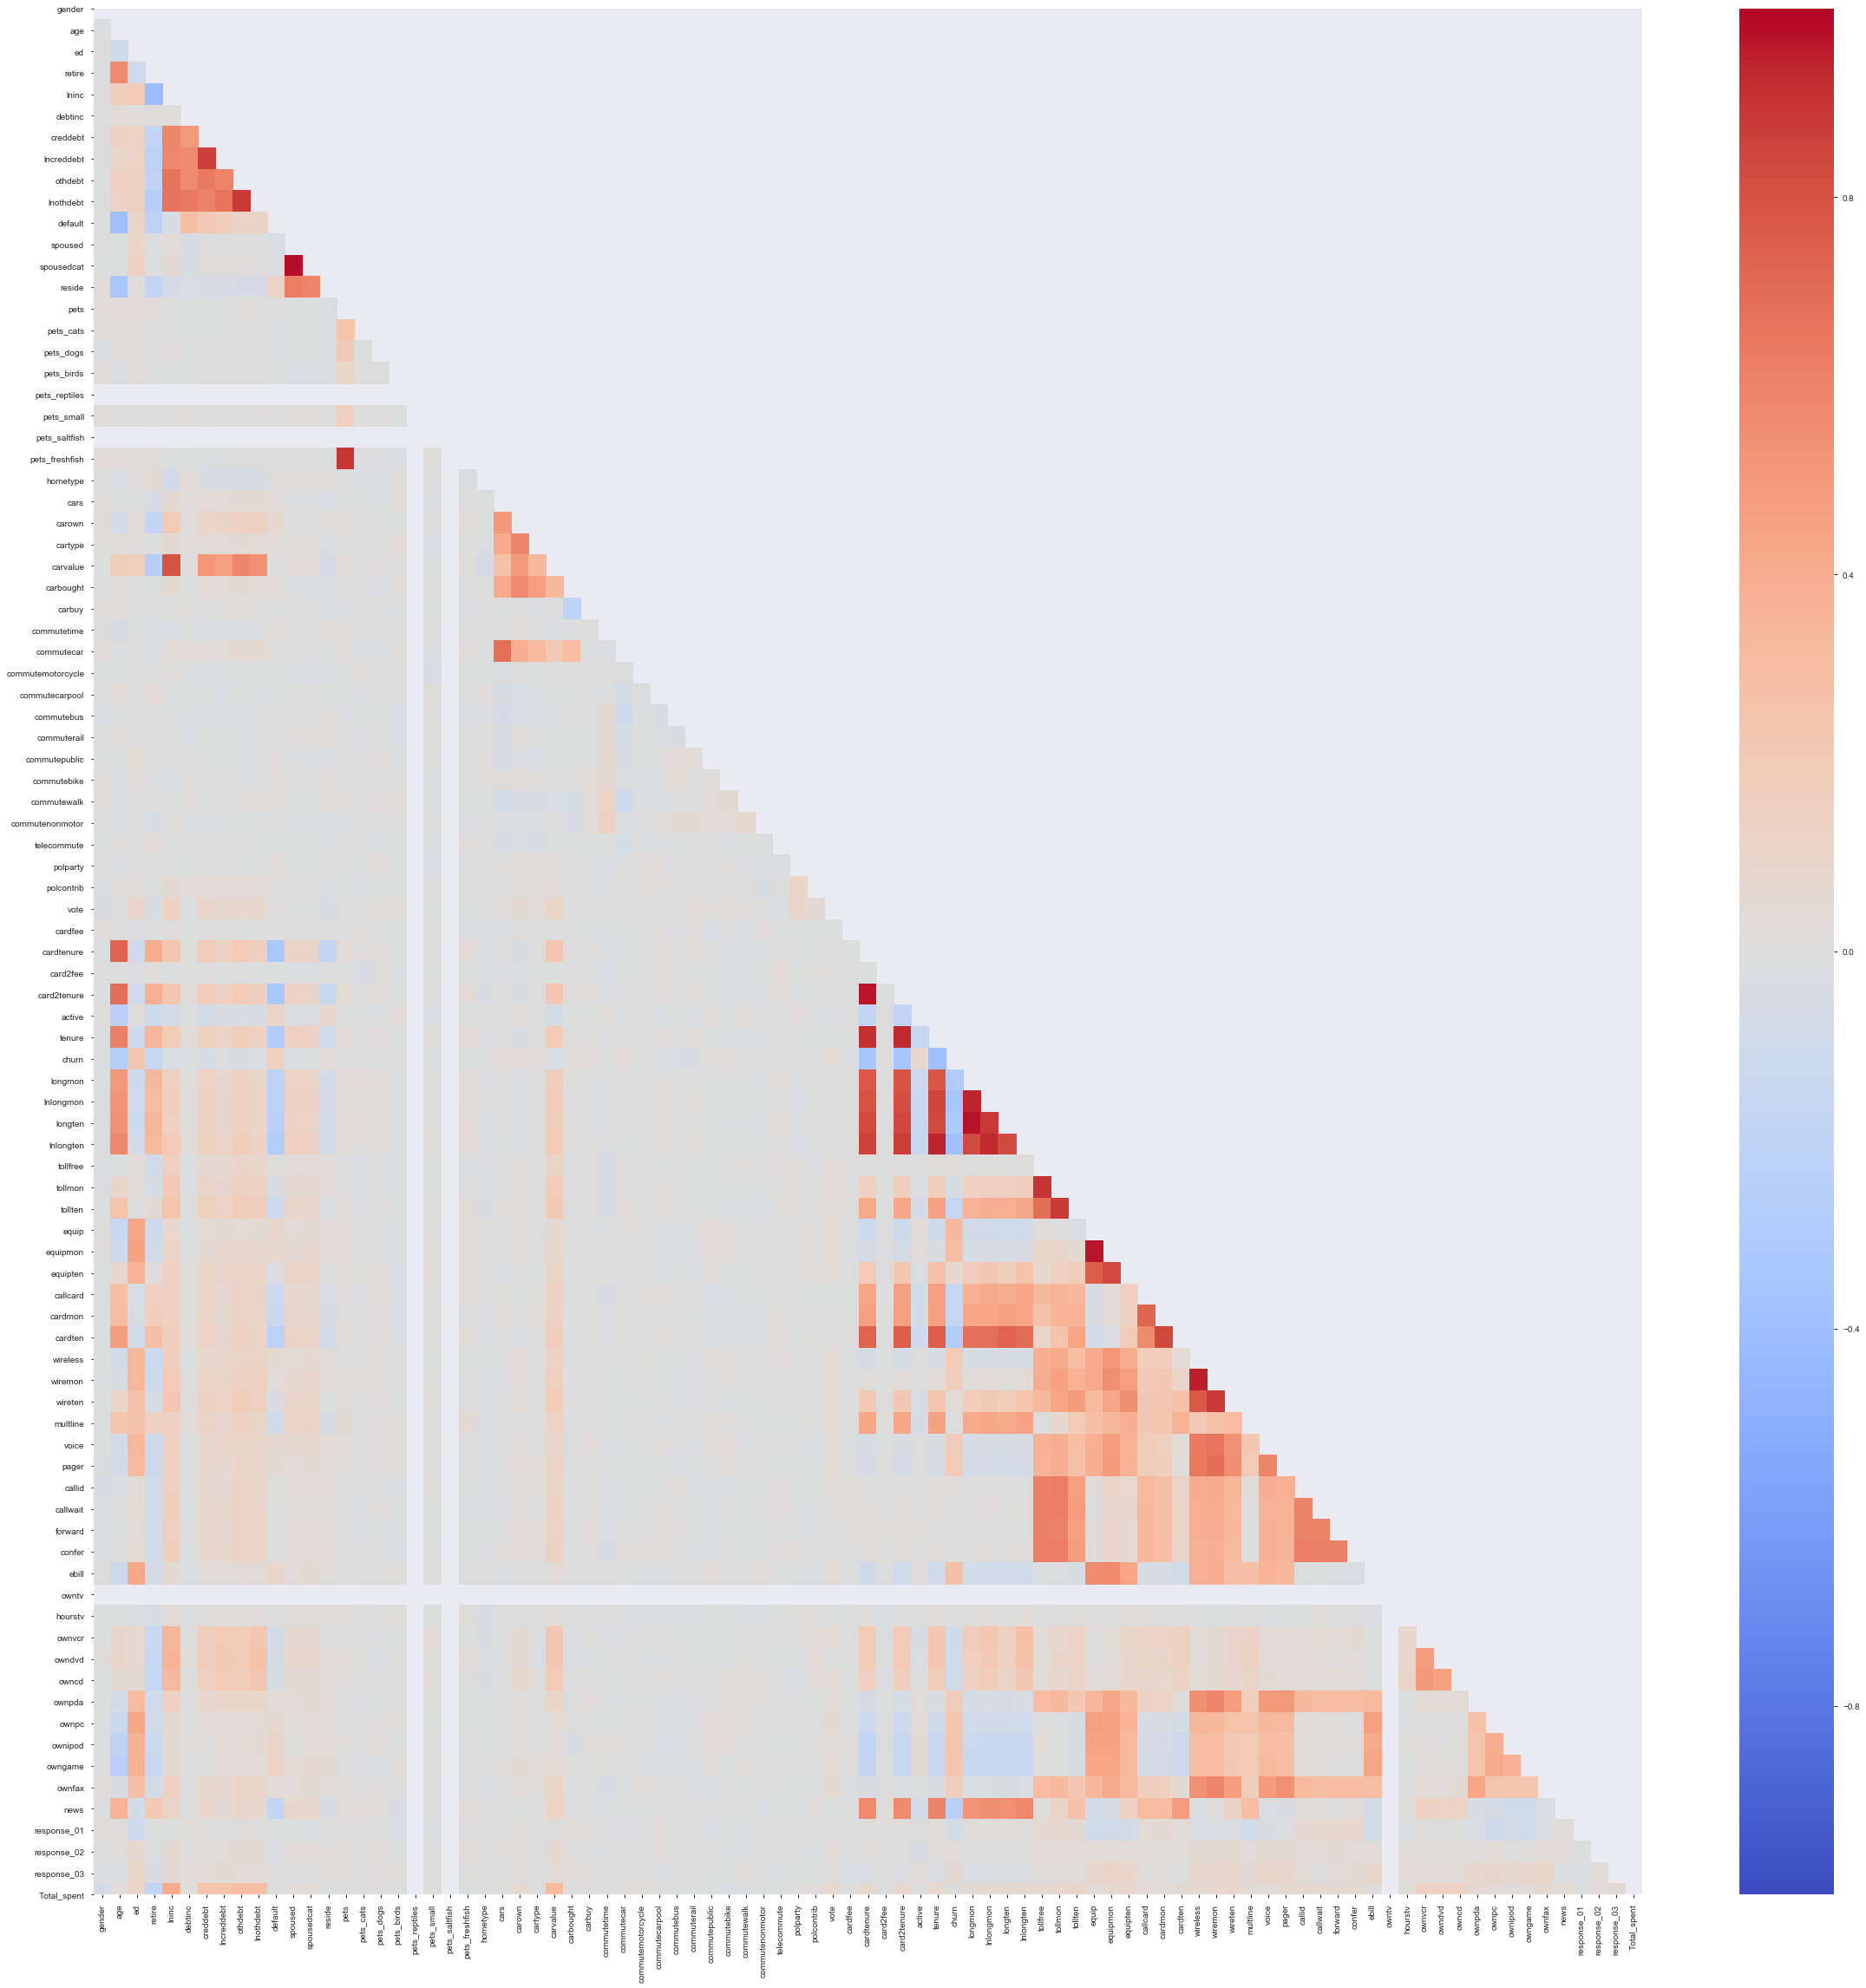

In [38]:
mask = np.zeros_like(corrm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(40,40))
sns.heatmap(corrm,
            vmin=-1,
            cmap='coolwarm',
            mask = mask);

### Treating ordinal variables

In [39]:
col=list(card_spend_cat.columns)

In [40]:
# get the useful categorical variables


# for c_feature in categorical_features
for c_feature in col:
    card_spend[c_feature] = card_spend[c_feature].astype('category')
    card_spend = create_dummies(card_spend, c_feature)
    
# see the data in the output
card_spend

,gender,age,ed,retire,lninc,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,...,card2tenurecat_2,card2tenurecat_3,card2tenurecat_4,card2tenurecat_5,bfast_2,bfast_3,internet_1,internet_2,internet_3,internet_4
0,0,22,17,0,2.708050,18.6,1.222020,0.200505,1.567980,0.449788,...,1,0,0,0,0,0,0,0,0,1
1,0,44,10,0,4.290459,2.8,1.250928,0.223886,0.793072,-0.231841,...,0,0,0,0,0,1,1,0,0,0
2,0,63,14,0,4.990433,10.7,6.373010,1.852297,11.815981,2.469586,...,0,0,0,1,0,0,0,0,0,0
3,1,28,11,0,3.135494,4.8,0.190992,-1.655524,0.913008,-0.091011,...,0,1,0,0,0,0,0,0,0,0
4,1,26,16,0,3.178054,11.7,1.297296,0.260282,1.510704,0.412576,...,1,0,0,0,0,1,0,0,0,1
5,0,36,19,0,3.401197,15.5,0.413850,-0.882252,4.236150,1.443655,...,0,0,1,0,0,1,0,1,0,0
6,0,75,11,1,2.564949,2.4,0.101088,-2.291604,0.287692,-1.243483,...,0,0,1,0,1,0,0,0,0,0
7,0,25,14,0,3.912023,10.5,1.218000,0.197210,4.032000,1.394263,...,0,1,0,0,0,0,0,1,0,0
8,0,76,11,1,3.332205,9.8,1.635424,0.491902,1.108576,0.103076,...,0,0,1,0,1,0,0,0,0,0
9,0,47,19,0,4.317488,2.2,0.102300,-2.279846,1.547700,0.436770,...,0,0,1,0,0,1,0,0,0,0


In [41]:
#card_spend_new = pd.concat([card_spend_nominal, card_spend_num], axis = 1)

In [42]:
card_spend.shape

(5000, 176)

## Assumptions check

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


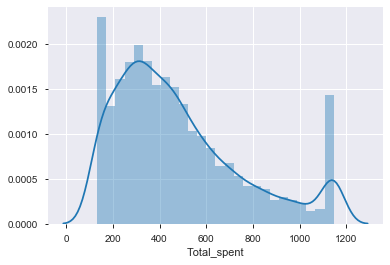

In [43]:
# Very first assumtion is that all the variables should be normally distributed, however that can't be possible
# However we have to be atleast strict about the dependant Y variable

# Distribution of variables

sns.distplot(card_spend['Total_spent'])

# this distribution is highly skewed

# Notes:
#-----------------------------------------------------
# 1. if we get skewed data, then we have to transform the data and there are multiple methods to go about it
# 2. most commonly used and which works on most of the data is log transformation
# 3. Ideally we can do this for each of the dependant variable as well, 
#    however it will depend on amount of data and the amount of analytical rigour
# 4. In no case we can proceed if dependant variable is not normal/near to normal distributed

In [44]:
# Note: good practice is to take the log of the data plus 1, bcoz we don't have log of zero defined
# In thios data its not required as sales are always greater than zero

# apply log transformation: log is rescalling the data and making the distribution normal

card_spend['log_Total_spent']=np.log(card_spend.Total_spent+1)

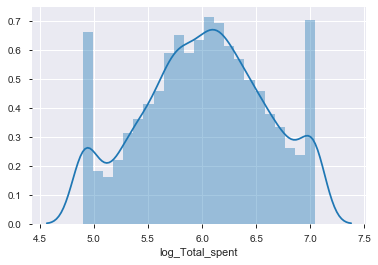

In [45]:
# Distribution of variables
sns.distplot(card_spend['log_Total_spent'])
plt.show()

## Splitting data into training and testing

In [46]:
feature_columns=card_spend.columns.difference(['log_Total_spent', 'Total_spent'])

In [47]:
feature_columns

Index(['active', 'addresscat_2', 'addresscat_3', 'addresscat_4',
       'addresscat_5', 'age', 'agecat_3', 'agecat_4', 'agecat_5', 'agecat_6',
       ...
       'tenure', 'tollfree', 'tollmon', 'tollten', 'union_1', 'voice', 'vote',
       'wireless', 'wiremon', 'wireten'],
      dtype='object', length=175)

In [48]:
# method 1: divide the data into training and testing and separate out Y and X variables
# this will be used in sklearn related functions
train, test = train_test_split(card_spend, test_size = 0.3, random_state = 123)

In [49]:
#method 2
train_X,test_X,train_y, test_y=train_test_split(card_spend[feature_columns],card_spend['log_Total_spent'], test_size=0.3, random_state=123)

In [50]:
print(train_X.shape)
print(test_X.shape)

(3500, 175)
(1500, 175)


In [51]:
print(train_y.shape)
print(test_y.shape)

(3500,)
(1500,)


## Linear Regresson_model fitting (Statistical Approach)

In [52]:
#Feature importance

In [53]:
# Importing Module for performing RFE

from sklearn.feature_selection import RFE
#  Initializing RFE model with using 32 as input to have the 8 most important features in the output.
linreg_model=linear_model.LinearRegression()
rfe = RFE(linreg_model,51)
# Fitting RFE Model

rfe = rfe.fit(train_X, train_y)

# Printing the 32 selected Features

print('Selected features: %s' % list(train_X.columns[rfe.support_]))

Selected features: ['agecat_3', 'agecat_4', 'callcard', 'carcatvalue_1', 'carcatvalue_2', 'carcatvalue_3', 'card2_2', 'card2_3', 'card2_4', 'card2_5', 'card2benefit_3', 'card2tenurecat_2', 'card_2', 'card_3', 'card_4', 'card_5', 'cardfee', 'cardtenurecat_3', 'cardtenurecat_4', 'cardtenurecat_5', 'churn', 'commutebike', 'commutecat_5', 'default', 'ebill', 'edcat_5', 'empcat_5', 'gender', 'inccat_2', 'inccat_3', 'inccat_4', 'inccat_5', 'internet_3', 'internet_4', 'jobcat_5', 'jobcat_6', 'jobsat_3', 'jobsat_5', 'lninc', 'lnlongmon', 'lnlongten', 'multline', 'owndvd', 'pets_birds', 'polview_7', 'reason_2', 'reason_9', 'region_5', 'response_01', 'telecommute', 'union_1']


In [54]:
selected_cols=list(train_X.columns[rfe.support_])

In [55]:
## Making first model with all 32 selected features

In [56]:
# get all the independant variables for model creation
model_param = 'log_Total_spent ~ ' + ' + '.join(selected_cols)


In [57]:
# Step 1 and Step 2: define Y, X and build a ols model
m1= smf.ols(model_param, train).fit()

In [58]:
# Step 3: get the output summary of the model
print(m1.summary())

                            OLS Regression Results                            
Dep. Variable:        log_Total_spent   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     38.43
Date:                Mon, 25 Nov 2019   Prob (F-statistic):          1.30e-293
Time:                        20:30:47   Log-Likelihood:                -2236.6
No. Observations:                3500   AIC:                             4577.
Df Residuals:                    3448   BIC:                             4898.
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.2304      0.156  

## Variance Inflation factor

In [59]:
# High VIF of the variable means information in that variable has already been explained by 
# other X variables present in the model

model_param1='log_Total_spent ~ ' + ' + '.join(selected_cols)

# import the packages for vif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# separate the Y and X variables
y, X = dmatrices(model_param1,train , return_type = 'dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# display the output
vif.sort_values(by='VIF Factor', ascending=False)

,Features,VIF Factor
0,Intercept,401.401129
39,lninc,18.410713
41,lnlongten,14.949406
32,inccat_5,12.951050
31,inccat_4,12.015981
40,lnlongmon,8.991418
30,inccat_3,8.588640
20,cardtenurecat_5,8.228984
29,inccat_2,5.375530
6,carcatvalue_3,4.215873


In [60]:
#Here I have taken min value of VIF to be 4
a=list(vif[vif['VIF Factor']<4].Features)

In [61]:
a

['agecat_3',
 'agecat_4',
 'callcard',
 'carcatvalue_1',
 'carcatvalue_2',
 'card2_2',
 'card2_3',
 'card2_4',
 'card2_5',
 'card2benefit_3',
 'card2tenurecat_2',
 'card_2',
 'card_3',
 'card_4',
 'card_5',
 'cardfee',
 'cardtenurecat_3',
 'cardtenurecat_4',
 'churn',
 'commutebike',
 'commutecat_5',
 'default',
 'ebill',
 'edcat_5',
 'empcat_5',
 'gender',
 'internet_3',
 'internet_4',
 'jobcat_5',
 'jobcat_6',
 'jobsat_3',
 'jobsat_5',
 'multline',
 'owndvd',
 'pets_birds',
 'polview_7',
 'reason_2',
 'reason_9',
 'region_5',
 'response_01',
 'telecommute',
 'union_1']

## Lets construct the model after removing variables having high VIF

In [62]:
## Creating model by removing variables having high multicollinearilty 

In [63]:
model_param2='log_Total_spent ~  ' + ' + '.join(a)


In [64]:
# Step 1 and Step 2: define Y, X and build a ols model
m2= smf.ols(model_param2, train).fit()

In [65]:
print(m2.summary())

                            OLS Regression Results                            
Dep. Variable:        log_Total_spent   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     36.19
Date:                Mon, 25 Nov 2019   Prob (F-statistic):          3.66e-238
Time:                        20:31:30   Log-Likelihood:                -2386.5
No. Observations:                3500   AIC:                             4859.
Df Residuals:                    3457   BIC:                             5124.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            6.7208      0.056  

In [66]:
#  predict the sales on the training data
train['pred_spend'] = np.exp(m2.predict(train))


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [67]:
# predict the sales on the testing/validation data
test['pred_spend'] = np.exp(m2.predict(test))


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [68]:
# accuracy metrics (a. MAPE: Mean Absolute Percentage Error)
MAPE_train = np.mean(np.abs(train['Total_spent'] - train['pred_spend'])/train['Total_spent'])

MAPE_test = np.mean(np.abs(test['Total_spent'] - test['pred_spend'])/test['Total_spent'])

# print the values of MAPE for train and test
print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)

MAPE of training data:  0.4266907703355171  |  MAPE of testing data:  0.45669013964442795


In [69]:
#  accuracy metrics (d. Decile Analysis: for validation of models - Business validation)

# create the 10 groups in the data
train['Deciles'] = pd.qcut(train['pred_spend'], 10, labels = False)
test['Deciles'] = pd.qcut(test['pred_spend'], 10, labels = False)

# Decile Analysis for train data
Predicted_avg = train[['Deciles', 'pred_spend']].groupby(train.Deciles).mean().sort_index(ascending = False)['pred_spend']
Actual_avg = train[['Deciles', 'Total_spent']].groupby(train.Deciles).mean().sort_index(ascending = False)['Total_spent']
Decile_analysis_train = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()

# Decile Analysis for test data
Predicted_avg = test[['Deciles', 'pred_spend']].groupby(test.Deciles).mean().sort_index(ascending = False)['pred_spend']
Actual_avg = test[['Deciles', 'Total_spent']].groupby(test.Deciles).mean().sort_index(ascending = False)['Total_spent']
Decile_analysis_test = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [70]:
Decile_analysis_train

,Deciles,pred_spend,Total_spent
0,9,748.187451,791.518377
1,8,602.067945,667.854389
2,7,516.551945,568.067363
3,6,451.839496,546.358604
4,5,411.561302,479.648747
5,4,380.518266,401.347434
6,3,348.400912,364.231024
7,2,319.267580,363.262853
8,1,292.815283,326.653046
9,0,259.392588,299.151183


In [71]:
Decile_analysis_test

,Deciles,pred_spend,Total_spent
0,9,749.416990,739.350433
1,8,604.674205,655.523897
2,7,517.725241,587.549577
3,6,457.546120,481.929317
4,5,414.569251,465.946553
5,4,380.672447,425.582770
6,3,348.735067,391.873413
7,2,317.821864,367.703453
8,1,292.084847,342.264853
9,0,256.471845,298.354120


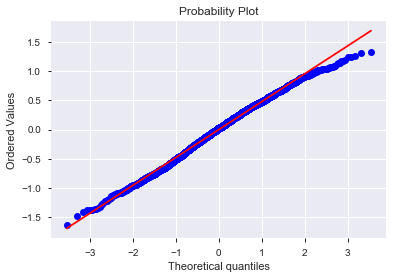

In [72]:
# assumption: Normality of the residuals/error (using Q-Q plot)
from scipy import stats
import pylab

stats.probplot(m2.resid, dist = 'norm', plot = pylab)
pylab.show()

# If errors are normally and randomly distributed, they would be following a straight line pattern
# Q-Q plot shows if the residuals are plotted along the line

## Dealing influential observations

In [73]:
#Creating summary
infl = m2.get_influence()
sm_fr = infl.summary_frame()

In [74]:
sm_fr

,dfb_Intercept,dfb_agecat_3,dfb_agecat_4,dfb_callcard,dfb_carcatvalue_1,dfb_carcatvalue_2,dfb_card2_2,dfb_card2_3,dfb_card2_4,dfb_card2_5,...,dfb_region_5,dfb_response_01,dfb_telecommute,dfb_union_1,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
4036,-0.062435,0.014423,0.028701,0.058122,0.053506,0.049616,-0.045904,-0.000874,-0.019754,-0.005770,...,0.014549,0.011469,0.014585,0.009260,7.913870e-04,-1.814148,0.010234,-0.184471,-1.814750,-0.184532
2883,0.024730,0.049389,0.015991,-0.022931,-0.008145,-0.005143,0.022650,0.005267,0.001378,-0.008228,...,-0.015436,-0.003127,-0.007399,-0.002762,5.323301e-04,1.159810,0.016732,0.151295,1.159867,0.151303
4162,0.003693,-0.001571,0.003428,-0.004930,-0.003169,-0.004131,-0.005058,-0.004977,-0.003868,-0.002692,...,-0.001685,-0.000635,-0.001646,-0.000846,8.399516e-06,0.178799,0.011172,0.019005,0.178774,0.019002
4640,-0.008927,0.004337,0.012239,-0.010144,-0.015294,-0.000780,-0.007160,0.008030,0.001261,-0.058301,...,0.011721,0.012194,0.010714,-0.049354,4.145589e-04,-1.137452,0.013591,-0.133514,-1.137500,-0.133520
2430,-0.024101,0.004194,0.034380,0.020699,0.015725,-0.005983,0.007842,-0.004686,0.025672,-0.004168,...,-0.009251,-0.007975,-0.007396,-0.006066,2.286616e-04,1.023516,0.009299,0.099159,1.023523,0.099159
449,-0.010503,0.007188,-0.001147,0.004837,0.000591,0.006325,0.008725,0.000130,0.002528,0.002644,...,0.009651,-0.001379,-0.001611,-0.002241,3.107827e-05,0.308401,0.013856,0.036556,0.308361,0.036552
4179,0.000150,0.000245,0.000216,0.000284,-0.000020,-0.000249,-0.000338,-0.000089,-0.000115,-0.000105,...,0.000130,0.000012,0.000062,-0.000424,4.820080e-08,-0.009678,0.021648,-0.001440,-0.009677,-0.001439
4763,0.005510,-0.007501,0.007458,-0.007446,-0.000089,0.008664,-0.014966,-0.011081,-0.014025,-0.010277,...,-0.003432,-0.000457,-0.003225,-0.003416,5.075977e-05,0.408060,0.012939,0.046719,0.408010,0.046713
749,0.000309,0.008068,0.006050,-0.008966,-0.004591,0.000534,0.003668,-0.006254,0.005148,0.000641,...,-0.015375,0.000193,0.003098,0.003089,6.984798e-05,-0.416752,0.016999,-0.054804,-0.416702,-0.054797
2525,-0.004788,0.001805,0.001861,0.003327,-0.001998,-0.000077,0.001180,-0.001560,0.001515,0.000651,...,0.000679,0.000302,0.001152,0.000775,4.108759e-06,-0.115212,0.013135,-0.013292,-0.115196,-0.013290


In [229]:
# Checking the values of cooks_d
sm_fr.cooks_d.head()

4036    0.000791
2883    0.000532
4162    0.000008
4640    0.000415
2430    0.000229
Name: cooks_d, dtype: float64

In [75]:
# Concatenate the cooks_d column with the training data.
card_spend_final=pd.concat([sm_fr.cooks_d, train],axis=1)

In [76]:
card_spend_final.shape

(3500, 180)

In [77]:
# Applying the formula and slicing out the data where cooks_d is less than 4/3500
final_data=card_spend_final[card_spend_final['cooks_d'] < (4/3500)]

In [78]:
final_data.head()

,cooks_d,gender,age,ed,retire,lninc,debtinc,creddebt,lncreddebt,othdebt,...,card2tenurecat_5,bfast_2,bfast_3,internet_1,internet_2,internet_3,internet_4,log_Total_spent,pred_spend,Deciles
4036,0.000791,1,56,14,0,4.369448,14.0,6.071940,1.803678,4.988060,...,0,1,0,0,0,0,0,4.902085,320.879869,2
2883,0.000532,1,34,12,0,3.761200,16.6,4.803874,1.569423,2.334126,...,0,0,0,0,0,0,0,6.232998,292.736378,1
4162,0.000008,1,47,17,0,4.290459,1.9,0.303315,-1.192983,0.791685,...,0,1,0,0,0,1,0,6.465880,590.090319,8
4640,0.000415,1,52,9,0,3.367296,6.7,0.101088,-2.291604,1.886653,...,0,0,1,1,0,0,0,5.089754,279.687379,1
2430,0.000229,1,46,9,0,3.465736,8.1,0.476928,-0.740390,2.115072,...,0,0,1,0,0,0,0,6.151562,287.454080,1


## Final model

In [79]:
###Model making after removing influential observations

In [80]:
feature_columns1=final_data.columns.difference(['Total_spend', 'log_Total_spent'])

In [81]:
train1, test1=train_test_split(final_data, test_size=0.3, random_state=123)

In [82]:
train1_X,test1_X, train1_y, test1_y=train_test_split(final_data[feature_columns1],final_data['log_Total_spent'], test_size=0.3,random_state=123)

In [83]:
final_model=smf.ols('''log_Total_spent ~  card2_2 + card2_3 + hourstv  +
 card2_4 + card2_5 + card2benefit_3  + card_2 + card_3 + card_4 + card_5 + cardfee + cardtenurecat_3 + lninc+ cardmon + 
  commutebike + default  + gender  + owndvd  + reason_2 + reason_9 + ed + region_5 +  telecommute ''', train1).fit()


In [84]:
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:        log_Total_spent   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     71.27
Date:                Mon, 25 Nov 2019   Prob (F-statistic):          1.00e-248
Time:                        20:39:12   Log-Likelihood:                -1305.4
No. Observations:                2338   AIC:                             2659.
Df Residuals:                    2314   BIC:                             2797.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.6222      0.090     

In [85]:
#  predict the sales on the training data
train1['pred_spend'] = np.exp(final_model.predict(train1))


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [86]:
#  predict the sales on the training data
test1['pred_spend'] = np.exp(final_model.predict(test1))


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [87]:
# Step 6: accuracy metrics (d. Decile Analysis: for validation of models - Business validation)

# create the 10 groups in the data
train1['Deciles'] = pd.qcut(train1['pred_spend'], 10, labels = False)
test1['Deciles'] = pd.qcut(test1['pred_spend'], 10, labels = False)

# Decile Analysis for train data
Predicted_avg = train1[['Deciles', 'pred_spend']].groupby(train1.Deciles).mean().sort_index(ascending = False)['pred_spend']
Actual_avg = train1[['Deciles', 'Total_spent']].groupby(train1.Deciles).mean().sort_index(ascending = False)['Total_spent']
Decile_analysis_train = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()

# Decile Analysis for test data
Predicted_avg = test1[['Deciles', 'pred_spend']].groupby(test1.Deciles).mean().sort_index(ascending = False)['pred_spend']
Actual_avg = test1[['Deciles', 'Total_spent']].groupby(test1.Deciles).mean().sort_index(ascending = False)['Total_spent']
Decile_analysis_test = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [88]:
Decile_analysis_train

,Deciles,pred_spend,Total_spent
0,9,803.808555,849.080791
1,8,626.738427,672.448318
2,7,535.328311,577.739594
3,6,468.640715,512.336532
4,5,418.625975,448.116927
5,4,377.738114,436.536799
6,3,345.152152,374.646440
7,2,313.514873,339.903650
8,1,284.510887,315.315462
9,0,241.667441,260.346906


In [89]:
Decile_analysis_test

,Deciles,pred_spend,Total_spent
0,9,807.766983,832.967317
1,8,618.795391,692.250315
2,7,531.962300,572.353355
3,6,471.807819,535.844985
4,5,429.864401,478.422400
5,4,383.393036,414.143391
6,3,345.281739,364.846360
7,2,315.098935,356.089100
8,1,283.916066,310.049400
9,0,243.821193,278.873109


## Machine Learning Approach

In [90]:
# Initializing Model

linreg_model = linear_model.LinearRegression()

#dir(linreg_model)
#linear_model.LinearRegression?

In [91]:
# Fitting Model

ln_model=linreg_model.fit(train_X,train_y)

pred_y=ln_model.predict(test_X)
#metrics.r2_score(Y_train,y_pred)

#metrics.mean_absolute_error(Y_train,y_pred)
metrics.mean_absolute_error(test_y,pred_y)

0.3941303418783741

## Ridge Regression

In [92]:
# Initializing Model

tuned_parameters = [{'alpha': [0.01,0.1,1.,10.,100.,1000.]}]

RidgeCV = GridSearchCV(linear_model.Ridge(),
                   tuned_parameters,
                   cv=5,
                   n_jobs=-1,
                   scoring='neg_mean_squared_error',
                   verbose=2)

RidgeCV.fit(train_X,train_y)

print('Best combination:', RidgeCV.best_params_);

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best combination: {'alpha': 10.0}


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   16.8s finished


In [93]:
# Fitting Model

#Ridge=RidgeCV.best_params_
Ridge=linear_model.Ridge(alpha=10.0)


Ridge_model=Ridge.fit(train_X,train_y)

pred_y=Ridge_model.predict(test_X)
#metrics.r2_score(Y_train,y_pred)

metrics.mean_absolute_error(test_y,pred_y)

0.392898529001126

## Elastic Net Regression

In [94]:
# Initializing Model

tuned_parameters = [{'alpha': [0.0001,0.001,0.01,0.1,1.,10.,100.]}]

ElasticNet_CV = GridSearchCV(linear_model.ElasticNet(),
                   tuned_parameters,
                   cv=10,
                   n_jobs=-1,
                   scoring='neg_mean_squared_error')

ElasticNet_CV.fit(train_X,train_y)

print('Best combination:', ElasticNet_CV.best_params_);

Best combination: {'alpha': 0.001}


C:\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [95]:
# Fitting ModelEN
EN = linear_model.ElasticNet(alpha=0.001)
EN_model=EN.fit(train_X,train_y)

pred_y=EN_model.predict(test_X)


metrics.mean_absolute_error(test_y,pred_y)


C:\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.3909791643826568

In [96]:
coef = pd.Series(EN.coef_, index = train_X.columns)
imp_coef = coef.sort_values()
imp_coef.sort_values(ascending=False).head(15)

reason_2           0.319871
lninc              0.270507
reason_9           0.111193
region_5           0.058668
spousedcat         0.058336
cardtenurecat_2    0.056005
internet_4         0.053603
union_1            0.051031
default            0.041973
lnothdebt          0.039430
telecommute        0.037161
internet_3         0.035631
churn              0.031496
empcat_5           0.029403
commutecat_4       0.028112
dtype: float64

## Using Random Forest Classifier/Regressor

In [97]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

C:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [98]:
param_grd={'n_estimators':np.arange(10, 25)}

In [99]:
random_frst_model=GridSearchCV(estimator=RandomForestRegressor(random_state=123), param_grid=param_grd, cv=2, verbose=True, n_jobs=-1)
random_frst_results=random_frst_model.fit(train_X, train_y)

Fitting 2 folds for each of 15 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   49.6s finished


In [100]:
random_frst_results.best_params_

{'n_estimators': 24}

In [101]:
final_model_reg=RandomForestRegressor(oob_score=False, n_estimators=24, n_jobs=-1)
final_model_reg.fit(train_X, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=24, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [102]:
random_frst_pred=pd.DataFrame({'actual':test_y, 'predicted':final_model_reg.predict(test_X)})

In [103]:
print(metrics.r2_score(random_frst_pred.actual, random_frst_pred.predicted))
print(metrics.explained_variance_score(random_frst_pred.actual, random_frst_pred.predicted))

0.24354770842970297
0.24362049855374057


In [104]:
feature_importances = pd.DataFrame(final_model_reg.feature_importances_,
                                   index = train_X.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

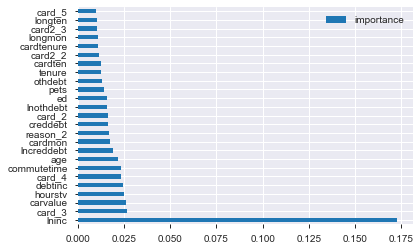

In [105]:

feature_importances.round(5).head(25).plot(kind='barh')

## Conclusion

The key drivers of the model are: 

- **card2_2**           
- **card2_3**           
- **hourstv**           
- **card2_4**           
- **card2_5**           
- **card2benefit_3**   
- **card_2**        
- **card_3**           
- **card_4**            
- **card_5**          
- **cardfee**          
- **cardtenurecat_3**  
- **lninc**            
- **cardmon**           
- **commutebike**      
- **default**          
- **gender**           
- **owndvd**          
- **reason_2**          
- **reason_9**         
- **ed**                
- **region_5**          
- **telecommute**

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


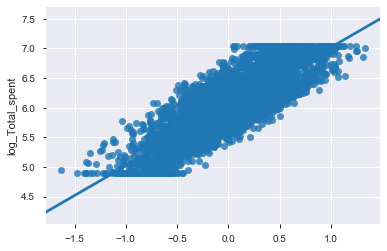

In [106]:
# assumption: homoscedasticity of residuals/errors
#!pip install --upgrade pip
#!pip install seaborn
import seaborn as sns

sns.regplot(x=m2.resid, y=train1.log_Total_spent)
#sns.jointplot(x=train.pred_sales, y=train.ln_sales_in_thousands)
#sns.scatterplot(x=train.pred_sales, y=train.ln_sales_in_thousands)
plt.show()

The given model is underfit, it has R squared value of approximately 40%. This model is not working well for the training data.

Only few features are contributing in making the model effective.
Thus, the above given factors are driving the Total Spend(Primary Card + Secondary Card and most features have weak correlation with the dependent variable.

## <span style="color:red"> Reasons of Underfitting</span>

- This is because most of the independent variables have weak/negative correlation with the dependent variable.
- Model is not complex and has noise.
- The variables are not explaining completely

## <span style="color:red">Solutions to improve model</span>

- Increase the size or number of parameters in the ML model.
- Increase the complexity or type of the model.
- Increasing the training time until cost function in ML is minimised.
- Using modeling techniques like Random Forest, XGBoost can boost the accuracy.

#### <span style="color:red"> Please have a look at the power point presentation to understand the model better </span>